# 패키지 Load

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 Load

In [ ]:
path='/content/drive/MyDrive/'+'path'

In [ ]:
subject = pd.read_csv(path)

In [ ]:
print(subject.shape)

(2342, 91)
(9935, 111)
(9669, 91)
(17443, 116)
(16881, 81)


# CNN Model

## Train / Test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(cal, cal['y'], test_size=0.3, shuffle=True, random_state=34)

In [ ]:
X_train_p.drop('y',axis=1,inplace=True)

In [ ]:
X_test_p.drop('y',axis=1,inplace=True)

In [ ]:
print(X_train_p.shape)
print(X_test_p.shape)

(6954, 110)
(2981, 110)


In [ ]:
X_train_p.fillna(0,inplace=True)
X_test_p.fillna(0,inplace=True)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train_dataset_p = TensorDataset(torch.FloatTensor(X_train_p.to_numpy()),torch.FloatTensor(y_train_p.to_numpy())) 
test_dataset_p = TensorDataset(torch.FloatTensor(X_test_p.to_numpy()),torch.FloatTensor(y_test_p.to_numpy()))

In [ ]:
train_dataloader_p = DataLoader(train_dataset_p, batch_size=1, shuffle=True)
test_dataloader_p = DataLoader(test_dataset_p, batch_size=1, shuffle=True)

## CNN Model Construction

In [ ]:
class model(nn.Module):

  def __init__(self,num_features,batch_size=1):
    super().__init__()

    self.num_curr = int(num_features/5)

    for i in range(self.num_curr):
      setattr(self, "emb_fc%d" % i, nn.Linear(5,1))

    self.fc0 = nn.Linear(18, 16)
    self.fc1 = nn.Linear(16, 8)
    self.fc2 = nn.Linear(8,1)
    self.relu = nn.ReLU()
    
  def forward(self,x):

    emb_tensor_list = []
    k = 1
    for i in range(self.num_curr):
      emb_tensor_list.append(getattr(self, "emb_fc%d" % i)(x[:,(k-1)*5:5*k]))
      k += 1
    x_emb = torch.cat(emb_tensor_list,0)
    y = self.fc0(x_emb.view(1,-1))
    y = self.relu(y)
    y = self.fc1(y)
    y = self.relu(y)
    y = self.fc2(y)

    return y

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
nn_prob = model(num_features = 90).to(device)

In [ ]:
optimizer_prob = torch.optim.Adam(params=nn_prob.parameters(),lr=0.001)
criterion = nn.MSELoss().to(device)

In [ ]:
seq_train_loss_prob = []
seq_test_loss_prob= []

## Train / Test

In [ ]:
# Train Def

def train_prob(epoch): 
    print(f'\n[ Train epoch: {epoch+1} ]')

    nn_prob.train() 

    running_loss = 0.0
    batch_losses = []

    for batch_idx, (inputs, targets) in enumerate(train_dataloader_p):


        inputs, targets = inputs.to(device), targets.to(device) 

        optimizer_prob.zero_grad() 
        outputs = nn_prob(inputs) 
        loss = criterion(outputs, targets) 
        loss.backward() 
        optimizer_prob.step() 

        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        if (batch_idx+1) % 1000 == 0:   # 중간결과 출력 주기
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 1000 batches: {running_loss / 1000}') 
            running_loss = 0.0
    #lr_scheduler.step()

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss_prob.append(avg_loss)
    print('Total train loss:', avg_loss)

In [ ]:
# Test Def

def test_prob(epoch):
    print(f'\n[ Test epoch: {epoch+1} ]')

    nn_prob.eval() 

    loss = 0
    batch_losses = []

    with torch.no_grad(): 
        for batch_idx, (inputs, targets) in enumerate(test_dataloader_p):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = nn_prob(inputs)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss_prob.append(avg_loss)
    print('Test average loss:', avg_loss)

In [ ]:
epoch = 50

In [ ]:
for i in range(0,epoch):
  train_prob(i)
  test_prob(i)


[ Train epoch: 1 ]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Current batch: 1000
Average train loss of recent 1000 batches: 0.47318339311071284
Total train loss: 0.4482617160338626

[ Test epoch: 1 ]
Test average loss: 0.39171557671497187

[ Train epoch: 2 ]

Current batch: 1000
Average train loss of recent 1000 batches: 0.33359195797429286
Total train loss: 0.337636252688529

[ Test epoch: 2 ]
Test average loss: 0.348378342088132

[ Train epoch: 3 ]

Current batch: 1000
Average train loss of recent 1000 batches: 0.29705516224037476
Total train loss: 0.2989534298869118

[ Test epoch: 3 ]
Test average loss: 0.3345830630946413

[ Train epoch: 4 ]

Current batch: 1000
Average train loss of recent 1000 batches: 0.2761171095870177
Total train loss: 0.2821023606148892

[ Test epoch: 4 ]
Test average loss: 0.3166880935186717

[ Train epoch: 5 ]

Current batch: 1000
Average train loss of recent 1000 batches: 0.255615580128365
Total train loss: 0.268384928630066

[ Test epoch: 5 ]
Test average loss: 0.32232179569888564

[ Train epoch: 6 ]

Current batch

KeyboardInterrupt: ignored

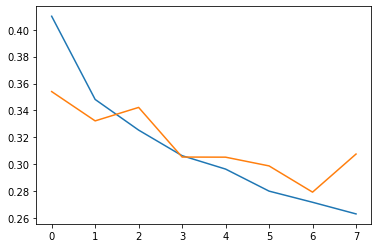

In [ ]:
plt.plot(seq_train_loss_prob)
plt.plot(seq_test_loss_prob)

In [ ]:
X = torch.cat([torch.Tensor(X_train_p.to_numpy()),torch.Tensor(X_test_p.to_numpy())])

In [ ]:
torch.save(nn_prob,'/content/drive/MyDrive/DSL/22-2/기업연계/nn_prob') # 결과 저장

In [ ]:
nn_prob

model(
  (emb_fc0): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc1): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc2): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc3): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc4): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc5): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc6): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc7): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc8): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc9): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc10): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc11): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc12): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc13): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc14): Linear(in_features=5, out_features=1, bias=True)
  (emb_fc15): Linear(in_features=5, out_features=1, bias=T

## embedding vector 생성

In [ ]:
new_fc = nn.Linear(8,8)
new_fc.weight.data = torch.Tensor(np.ones((8,8)))

In [ ]:
nn_res.fc2 = new_fc

In [ ]:
nn_res.fc2.weight

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)

In [ ]:
X_data = DataLoader(X, batch_size=1, shuffle=False)

In [ ]:
# Test Def

def get_emb(data):

    nn_res.eval()
    emb_vec = []
    with torch.no_grad(): 
      for input in X_data:
        inputs = input.to(device)
        outputs = nn_res(inputs)
        print(outputs.shape)
        emb_vec.append(outputs)
    
    return emb_vec

In [ ]:
emb = get_emb(X)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1,

In [ ]:
emb

[tensor([[4.4723, 4.4155, 4.0500, 4.1657, 4.6932, 4.3887, 4.1658, 4.2201]]),
 tensor([[1.7128, 1.6560, 1.2905, 1.4062, 1.9337, 1.6292, 1.4063, 1.4606]]),
 tensor([[2.4046, 2.3479, 1.9823, 2.0980, 2.6256, 2.3210, 2.0982, 2.1524]]),
 tensor([[2.9120, 2.8552, 2.4896, 2.6054, 3.1329, 2.8284, 2.6055, 2.6598]]),
 tensor([[1.3212, 1.2644, 0.8988, 1.0146, 1.5421, 1.2376, 1.0147, 1.0689]]),
 tensor([[1.6401, 1.5833, 1.2178, 1.3335, 1.8611, 1.5565, 1.3336, 1.3879]]),
 tensor([[2.5244, 2.4677, 2.1021, 2.2179, 2.7454, 2.4408, 2.2180, 2.2722]]),
 tensor([[2.2293, 2.1725, 1.8069, 1.9227, 2.4502, 2.1457, 1.9228, 1.9770]]),
 tensor([[3.5443, 3.4875, 3.1220, 3.2377, 3.7652, 3.4607, 3.2378, 3.2921]]),
 tensor([[2.7528, 2.6960, 2.3304, 2.4462, 2.9737, 2.6692, 2.4463, 2.5006]]),
 tensor([[3.3017, 3.2449, 2.8793, 2.9951, 3.5226, 3.2181, 2.9952, 3.0494]]),
 tensor([[3.0995, 3.0427, 2.6771, 2.7929, 3.3204, 3.0159, 2.7930, 2.8472]]),
 tensor([[1.5097, 1.4529, 1.0874, 1.2031, 1.7306, 1.4261, 1.2032, 1.2575]]),

In [ ]:
emb_arr_ = torch.stack(emb)

In [ ]:
emb_arr_ = emb_arr_.reshape([-1,8])

In [ ]:
emb_arr_ = emb_arr_.cpu().numpy()

In [ ]:
emb_arr_.shape

(9669, 8)

In [ ]:
emb_arr_

array([[4.4723067, 4.415528 , 4.049966 , ..., 4.3887053, 4.1658297,
        4.220077 ],
       [1.7127957, 1.6560167, 1.2904545, ..., 1.629194 , 1.4063187,
        1.4605659],
       [2.4046295, 2.3478503, 1.9822882, ..., 2.3210278, 2.0981524,
        2.1523998],
       ...,
       [1.7530396, 1.6962606, 1.3306984, ..., 1.6694379, 1.4465625,
        1.5008098],
       [4.3629475, 4.3061686, 3.9406066, ..., 4.279346 , 4.0564704,
        4.110718 ],
       [2.7443812, 2.687602 , 2.32204  , ..., 2.6607795, 2.4379041,
        2.4921515]], dtype=float32)

In [ ]:
np.save('/content/drive/MyDrive/DSL/22-2/기업연계/DATA/emb_vector_prob',emb_arr_) # embedding vector 저장

## Original Data와 Merge

In [ ]:
dat = pd.DataFrame(emb_arr_)

In [ ]:
ss = pd.read_csv('/content/drive/MyDrive/DSL/22-2/기업연계/DATA/hwak_column_84.csv')

In [ ]:
ids = ss.student_id

In [ ]:
from sklearn.model_selection import train_test_split
X_train_, X_test_ = train_test_split(ids, test_size=0.3, shuffle=True, random_state=34)

In [ ]:
stuid = pd.concat([X_train_, X_test_])

In [ ]:
stuid.values

array(['I173846', 'I179952', 'I131166', ..., 'I183555', 'I192107',
       'I224383'], dtype=object)

In [ ]:
dat.insert(0, 'student_id', stuid.values)

In [ ]:
dat.to_csv('/content/drive/MyDrive/DSL/22-2/기업연계/DATA/prob_emb.csv', index=False) # 결과 저장